# Knowledge Graph

In [1]:
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

In [2]:
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Load Text from Wiki

In [3]:
df_text = pd.read_csv('./data/wiki_sentences_v2.csv')
print(f'Total text: {df_text.shape[0]}')

Total text: 4318


In [4]:
df_text['sentence'].head()

0    confused and frustrated, connie decides to leave on her own.
1               later, a woman’s scream is heard in the distance.
2                        christian is then paralyzed by an elder.
3                                      the temple is set on fire.
4                               outside, the cult wails with him.
Name: sentence, dtype: object

## Check Entities (Subject, Object)

In [5]:
doc = nlp('the drawdown process is governed by astm standard d823')

for token in doc:
    print(token.text, '...', token.dep_) # using dependency parsing

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [6]:
doc = nlp('the drawdown process is governed by astm standard d823')

for token in doc:
    print(token.text, '...', token.pos_) # using pos tagging

the ... DET
drawdown ... ADJ
process ... NOUN
is ... AUX
governed ... VERB
by ... ADP
astm ... NOUN
standard ... PROPN
d823 ... PROPN


## Create Rules of Entities & Relation Extraction

#### 1) Extract Entities

In [7]:
def get_entities(sentence):
    
    entity1 = ''
    entity2 = ''
    
    prev_token_dep = '' # dependency tag of previous token in the sentence
    prev_token_text = '' # previous token in the sentence
    
    prefix = ''
    modifier = ''
    
    for token in nlp(sentence):
        
        # if token is a punctuation mark then move on to the next token
        if token.dep_ != 'punct':
            
            # check whether token is a compound word or not
            if token.dep_ == 'compound':
                prefix = token.text
                
                # if the previous word was also a 'compound' then add the current word to it
                if prev_token_dep == 'compound':
                    prefix = prev_token_text + ' ' + token.text
                    
            # check whether token is a modifier or not
            if token.dep_.endswith('mod') == True:
                modifier = token.text
                
                # if the previous word was also a 'compound' then add the current word to it
                if prev_token_dep == 'compound':
                    modifier = prev_token_text + ' ' + token.text
                    
            if token.dep_.find('subj') == True:
                if prefix:
                    entity1 = modifier + ' ' + prefix + ' ' + token.text
                else:
                    entity1 = modifier + ' ' + token.text
                    
                prefix = ''
                modifier = ''
                prev_token_dep = ''
                prev_token_text = ''
            
            if token.dep_.find('obj') == True:
                if prefix:
                    entity2 = modifier + ' ' + prefix + ' ' + token.text
                else:
                    entity2 = modifier + ' ' + token.text
                
            # update variables
            prev_token_dep = token.dep_
            prev_token_text = token.text
            
    return [entity1.strip(), entity2.strip()]

In [8]:
# test the rule with sample sentence
sample_sentence = 'The film had 200 patents'
get_entities(sample_sentence)

['film', '200 patents']

In [9]:
entity_pairs = [] 

for sentence in tqdm(df_text['sentence']):
    entity_pairs.append(get_entities(sentence))

100%|██████████| 4318/4318 [00:41<00:00, 103.67it/s]


In [10]:
entity_pairs[:10]

[['connie', 'own'],
 ['later woman', '’s distance'],
 ['christian', 'then elder'],
 ['temple', 'fire'],
 ['outside cult', 'him'],
 ['it', 'religious awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian maniscalco', 'later paul ben cast'],
 ['we', 'just film']]

#### 2) Extract Relations

In [11]:
def get_relation(sentence):
    
    document = nlp(sentence)
    
    # use matcher spacy
    matcher = Matcher(nlp.vocab)
    
    # define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': '?'},
               {'DEP': 'agent', 'OP': '?'},
               {'POS': 'ADJ', 'OP': '?'}]
    
    matcher.add('matching_1', None, pattern)
    
    matches = matcher(document)
    k = len(matches) - 1
    
    span = document[matches[k][1]:matches[k][2]]
    
    return span.text

In [12]:
# test the rule with sample sentence
sample_sentence = 'John completed the task'
get_relation(sample_sentence)

'completed'

In [13]:
relations = [get_relation(sentence) for sentence in tqdm(df_text['sentence'])]

100%|██████████| 4318/4318 [00:40<00:00, 107.65it/s]


In [14]:
pd.Series(relations).value_counts()[:10]

is             371
was            297
released on     92
are             74
include         73
were            65
released        40
composed by     35
's              34
have            31
dtype: int64

## Build Knowledge Graph

In [15]:
# extract subject
source = [entity[0] for entity in entity_pairs]

# extract object
target = [entity[1] for entity in entity_pairs]

df_knowledge_graph = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [ ]:
df_knowledge_graph.head()

,edge,source,target
0,decides,connie,own
1,heard in,later woman,’s distance
2,paralyzed by,christian,then elder
3,set on,temple,fire
4,wails with,outside cult,him


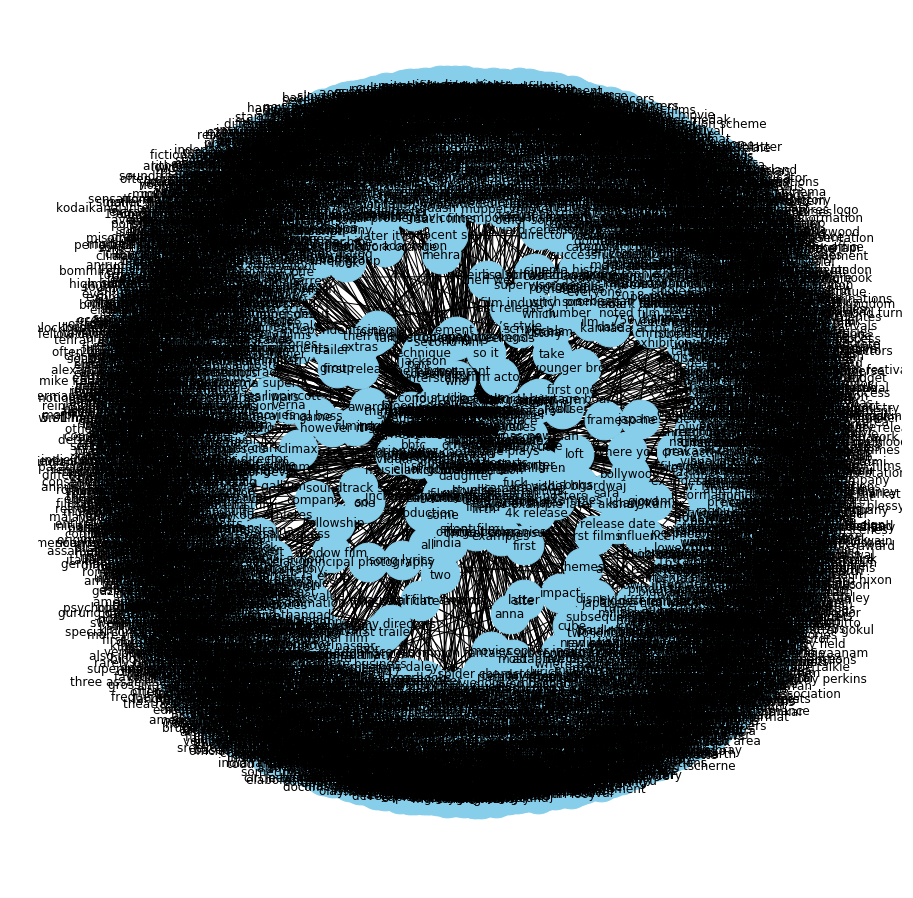

In [ ]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(df_knowledge_graph, 'source', 'target',
                            edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos, arrowstyle='->')

plt.show()

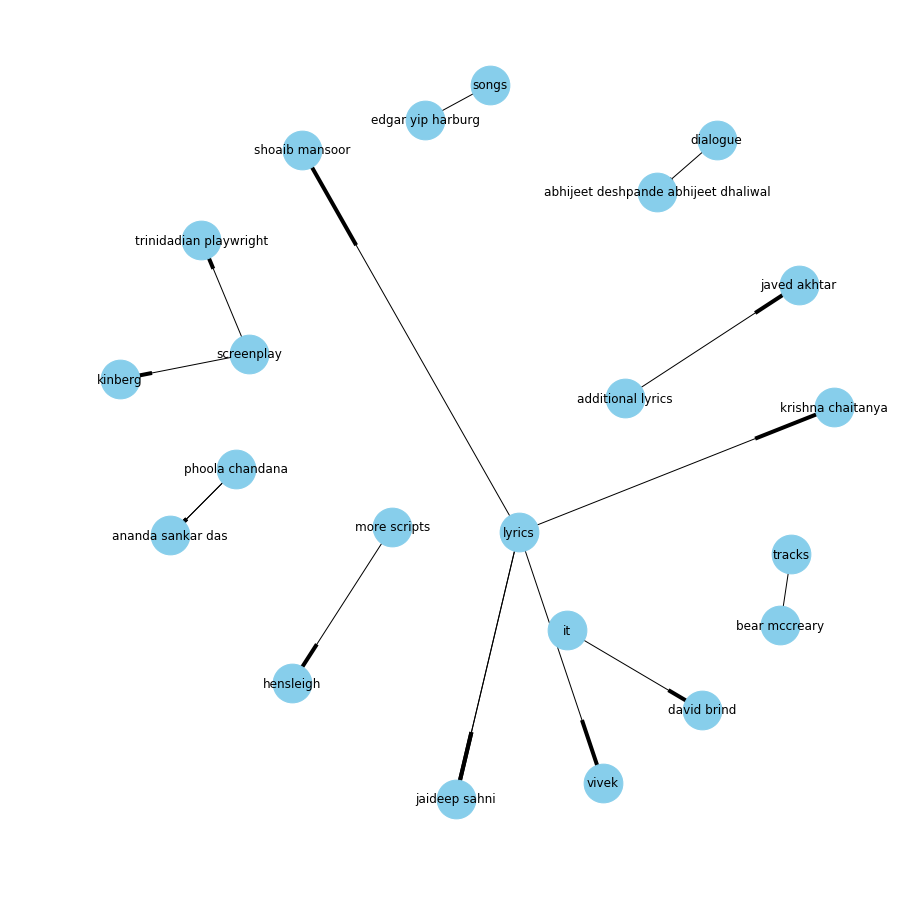

In [ ]:
# create a filtered directed-graph from a dataframe

filtered_by = 'composed by'
filtered_by = 'released in'
filtered_by = 'written by'

G = nx.from_pandas_edgelist(df_knowledge_graph[df_knowledge_graph['edge'] == filtered_by], 'source', 'target',
                            edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos, arrowstyle='->')

plt.show()

---